In [3]:
import warnings
warnings.filterwarnings("ignore")

#  Model Explainability: Fraud Detection

This notebook explores the explainability of our fraud detection model using **SHAP (SHapley Additive exPlanations)**.

We’ll load the trained XGBoost model for the fraud dataset, apply SHAP to understand both **global** and **local** feature importance, and generate plots like the **summary plot** and **force plot**.

Our goal is to identify which features most influence fraud predictions and explain them clearly in our final report.

In [ ]:
import sys 
import os
import pandas as pd 
import shap
import joblib

sys.path.append(os.path.abspath("../"))
from src.utils.utils import load_data
from src.core.DataTransformer import FraudPreprocessor
from src.models.model_trainer import ModelTrainer

# Load dataset
df = pd.read_csv("../data/processed/Feature_engineered/Feature_engineered_fraud_data.csv")
X = df.drop(columns="class")
y = df["class"]

# Load model
model = joblib.load("../models/Fraud Model/xgboost_fraud.pkl")

# Prepare preprocessed data
preprocessor = FraudPreprocessor(mode="fraud_data", sampler="auto")
preprocessor.fit(X, y)
X_transformed = preprocessor.transform(X)

2025-07-24 21:32:34,891 - INFO - numexpr.utils - NumExpr defaulting to 4 threads.
2025-07-24 21:32:43,749 - INFO - fraud_pipeline - Fitting FraudPreprocessor for mode: fraud_data
2025-07-24 21:32:44,314 - INFO - fraud_pipeline - ColumnTransformer fitted
2025-07-24 21:32:44,317 - INFO - fraud_pipeline - Transforming data with trained encoders/scalers
2025-07-24 21:32:44,589 - INFO - fraud_pipeline - Transformation complete → shape: (151112, 16)


100%|===================| 151101/151112 [11:26<00:00]        

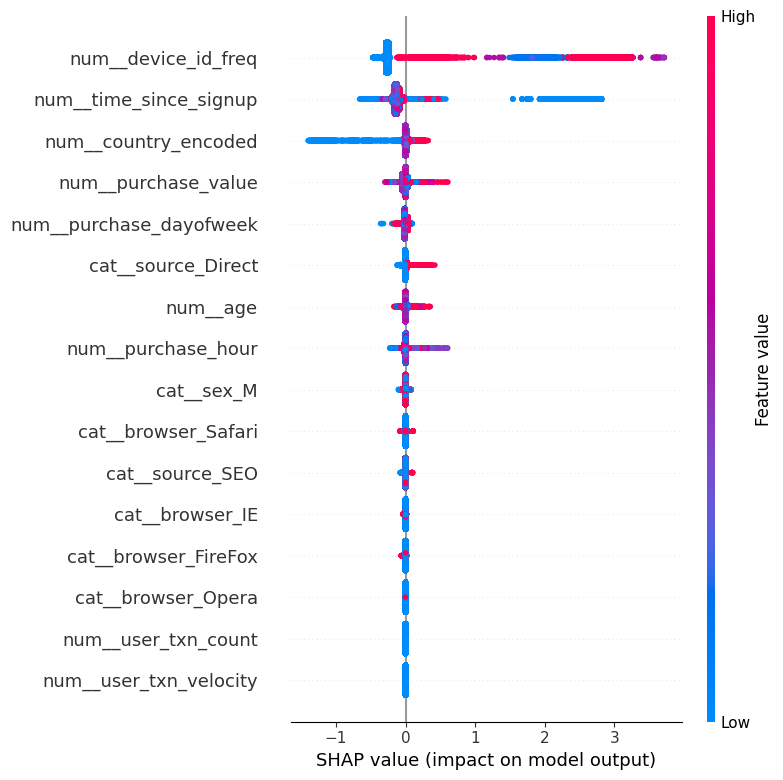

In [10]:
# Initialize SHAP Explainer
explainer = shap.Explainer(model, X_transformed)
shap_values = explainer(X_transformed)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_transformed)

## Interpretation of SHAP Summary Plot – Fraud Detection (Global Feature Importance)

This SHAP summary plot reveals the global influence of features in predicting fraud across the dataset. Here’s what we can interpret:

### Top Fraud Drivers:
- **device_id_freq**: The most influential feature. Higher device usage frequency appears to *increase* fraud likelihood — possibly signaling automated or bot-driven transactions.
- **country_encoded**: Regional fraud rates play a major role. Some countries are statistically more associated with fraud, even after encoding.
- **time_since_signup**: Users who signed up more recently are more fraud-prone, suggesting fraud often occurs shortly after account creation.
- **user_txn_velocity** and **purchase_value**: Sudden bursts of transaction activity or atypical purchase amounts also skew predictions toward fraud.
- **purchase_dayofweek**: Certain weekdays (e.g. weekends or Mondays) show different fraud behavior patterns.

### Categorical Feature Impact:
- Browsers like **Safari**, **Internet Explorer**, and **Opera** seem to be weak but relevant signals — likely proxies for device type or user behavior.
- **source_SEO** and **source_Direct**: These marketing sources slightly influence fraud predictions. Direct traffic might correlate with bot traffic in some cases.
- **sex_M**: May show mild correlation with fraud classification, though it's less impactful overall.

### Color Insights:
In the plot, each dot's color reflects the feature value (red = high, blue = low). For instance:
- High `device_id_freq` (red) points cluster to the right → high frequency pushes prediction *toward fraud*
- High `time_since_signup` values (red) cluster left → long-standing accounts lower fraud risk

These findings suggest that behavioral features (frequency, velocity, timing) and encoded region patterns are key fraud indicators. Categorical signals act more as supplementary features, nudging predictions but not dominating them.


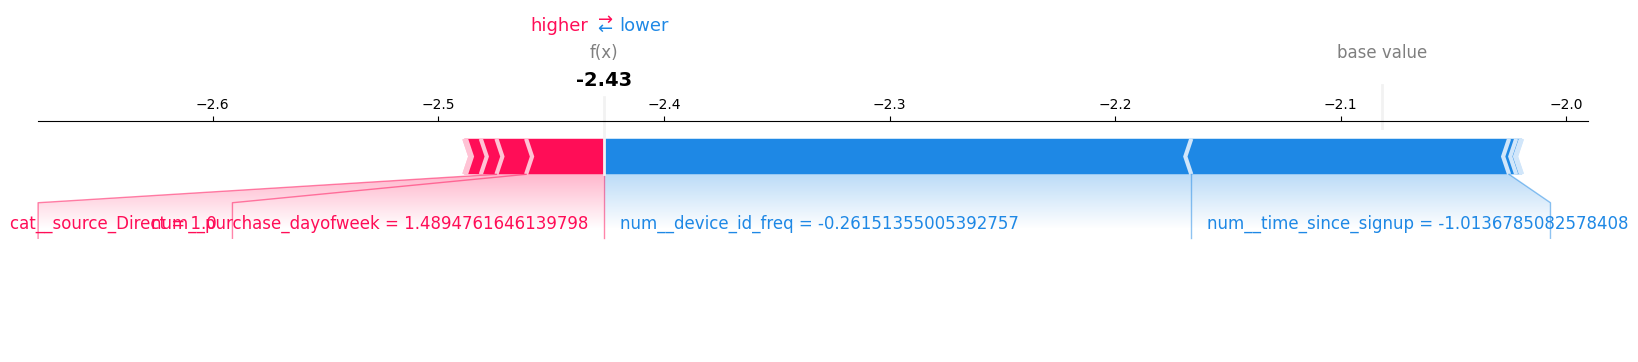

In [11]:
# Display a force plot for the first prediction
shap.force_plot(explainer.expected_value, shap_values[0].values, X_transformed.iloc[0], matplotlib=True)

## SHAP Force Plot – Local Explanation for a Single Prediction

This force plot helps us understand *why the model predicted “non-fraud”* for a specific user transaction. It visualizes how each feature pushed the decision either toward or away from fraud.

### Prediction Overview:
- **Base value** (average model prediction): `-2.0`
- **Final prediction for this sample**: `-2.43` → leaning even further *away* from fraud

### Feature Contributions:

1. **`cat__source_Directum1_purchase_dayofweek`**  
   ⬆️ **+1.49 SHAP value** → This feature *pushed toward fraud*. Possibly, a direct traffic source combined with a certain weekday raised the fraud suspicion.  
   ✴️ But: it wasn’t enough to override the other influences.

2. **`num__device_id_freq`**  
   ⬇️ **−0.26 SHAP value** → Lower device frequency helped *reduce* fraud prediction. This user’s device isn’t used repeatedly, lowering suspicion.

3. **`num__time_since_signup`**  
   ⬇️ **−1.01 SHAP value** → Strong contributor *against* fraud. This user has been signed up for a longer time, making fraud less likely.

### Net Effect:
The two features pulling *away* from fraud (device frequency + time since signup) had a **stronger combined influence** than the one pushing *toward* fraud (source + weekday). Hence, the final prediction moved leftward on the scale toward non-fraud.




## ✅ Final Summary – Model Explainability for Fraud Detection

In this notebook, we used SHAP to interpret our XGBoost model trained on the fraud dataset. Our analysis focused on two key explainability levels:

- **Global Interpretation (SHAP Summary Plot):**
  - Identified top features driving fraud predictions, such as `device_id_freq`, `time_since_signup`, and `country_encoded`.
  - Revealed how high feature values (e.g., high device frequency) consistently push predictions toward fraud.
  - Categorical features like browser type and traffic source provide supplementary signals, influencing decisions less strongly.

- **Local Interpretation (SHAP Force Plot):**
  - Explained a specific prediction for one transaction.
  - Showed how individual feature contributions push the model’s decision toward or away from fraud.
  - Demonstrated how positive and negative SHAP values balance to form the final prediction.

This analysis deepens our understanding of how behavior patterns and encoded signals shape fraud detection, offering transparency for stakeholders and actionable insights for model refinement.